# Introduction
A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

In [4]:
#The proportion of users converted.
round(df["converted"].mean(), 2)

0.12

In [5]:
#The number of times the new_page and treatment don't line up.
df.groupby(["landing_page"])["group"].value_counts()

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

In [6]:
#any of the rows have missing values?
df.isnull().sum().sum()

0

For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. 

In [7]:
# define a new dataframe df2 from df where we excluded the 3893 records where new_page and trement didn't line up
df2=df[
    (df["landing_page"] =="new_page") & (df["group"] =="treatment") |
    (df["landing_page"] =="old_page") & (df["group"] =="control")] 

df2.shape

(290585, 5)

In [8]:
# df2 = df.drop(
#     df.query(
#     '(group == "treatment" and landing_page != "new_page") or (group == "control" and landing_page != "old_page")'
#              )
#             .index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2["landing_page"] =="new_page") == (df2["group"] =="treatment")) == False].shape[0]

0

In [10]:
#How many unique user_ids are in df2?
df2["user_id"].nunique()

290584

There is one user_id repeated in df2. What is it?

In [11]:
df2[df2["user_id"].duplicated()]["user_id"]

2893    773192
Name: user_id, dtype: int64

 What is the row information for the repeat user_id?


In [12]:
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.


In [13]:
df2=df2.drop_duplicates(subset='user_id')
df2.shape

(290584, 5)

What is the probability of an individual converting regardless of the page they receive?


In [14]:
round(df2["converted"].mean(), 2)

0.12

Given that an individual was in the control group, what is the probability they converted?


In [34]:
ctrl_conv = df2.query('group == "control"').converted.mean()
ctrl_conv

0.1203863045004612

Given that an individual was in the treatment group, what is the probability they converted?


In [35]:
treat_conv = df2.query('group == "treatment"').converted.mean()
treat_conv

0.11880806551510564

In [39]:
obs_diff = treat_conv - ctrl_conv 
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [40]:
(df2['landing_page'] == "new_page").mean()

0.5000619442226688

Descriptive statistics were applied to the data set. The results revealed some interesting facts about the data set. The overall conversion rate was about 11.95%, where as the control group had an conversion rate of 12.04%, while the treatment group showed slightly lower conversion rates of 11.88%. This indicates that the new landing page is not leading to any improvement in terms of conversion rate, considering that arrivals on the old and new landing page were almost equally distributed.

However, these results don't provide a solid evidence if one page leads to more conversions as we still don't know the significance of these results and the factors that might have contributed to the results above, such as change resistence or test time duration. In order to provide a meaningful information to support the decision whether to implement the new page or keep the old page, we need to define our test hypothesis and calculate p-value for the new and old pages.


Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?


What is the convert rate for $p_{new}$ under the null?

In [41]:
p_new = df2["converted"].mean()

What is the convert rate for $p_{old}$ under the null?

In [42]:
p_old = df2["converted"].mean()

In [43]:
diff_rate = p_new-p_old
diff_rate

0.0

What is $n_{new}$?

In [44]:
n_new = df2.query('landing_page == "new_page"')
n_new = n_new["user_id"].nunique()
n_new

145310

d. What is $n_{old}$?


In [45]:
n_old = df2.query('landing_page == "old_page"')
n_old = n_old["user_id"].nunique()
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. 

In [46]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted.mean()

0.11990227788865185

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null

In [47]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted.mean()

0.1195189779313573

In [48]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0003832999572945528

In [49]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs[:5]

[0.001126543666762403,
 0.0008718371830435112,
 0.0009614324014353554,
 -0.0016680030355657738,
 0.00037654772673181847]

In [52]:
p_diffs = np.asarray(p_diffs)

# histogram of the p_diffs

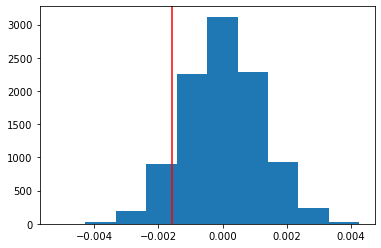

In [55]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

In [54]:
(p_diffs > obs_diff).mean()

0.9079

The value above represents the p-value of observing the statistic given the Null is true. As the p-value is large enough, we would fail to reject the Null hypothesis and keep the old page.

The number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [58]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

In [62]:
from scipy.stats import norm

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')

print('Our z-score is: ',z_score , 'but in order to reject the null hypothesis,''\n','our z-score needs to exceed the level of: ', norm.ppf(1-(0.05)), '\n'
     'since this was not the case, we failed to reject the null')

print('our p-value is:', p_value)

Our z-score is:  -1.3109241984234394 but in order to reject the null hypothesis,
 our z-score needs to exceed the level of:  1.6448536269514722 
since this was not the case, we failed to reject the null
our p-value is: 0.9050583127590245


In [63]:
#Shows the significance of the z_score
print(norm.cdf(z_score))

0.09494168724097551


In [64]:
# Assuming 95% CI for one-sided test

print(norm.ppf(1-(0.05)))

1.6448536269514722


The calculated p-value with the stats.proportions_ztest is almost the same value as we calculated manually. Thus, we can conclude based on the tests that there is no improvement in terms of the conversion rate by the new page.

# A regression approach

The goal is to use statsmodels to fit the regression model. to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [65]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [66]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

In [67]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-04-08 20:35 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

The null hypothesis in our logistic regression model argues that there is no relationship among the dependent and independent variables. In this case, we would state that the conversion is not related to the page that was shown (new page) to the user. The alternative would suggest that there is a relation between the page showed (new page) to the user and the conversion. So that the new page would lead to higher conversions.
Since the p-value (0.1897)in the logistic regression did not fall as well under the level of 0.05, we can argue that there is no relationship among the conversion of a user and the page that was shown to the user

In [68]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [70]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [71]:
### Create the necessary dummy variables

df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]

In [73]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1

log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'CA']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-04-08 20:42 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
==================================================================

"""

Looking at the results above, we may conclude there is no significant effect on the convertion based on the country.